### Credit Card Fraud Detection – Machine Learning Model

----- Author: [ László Dóczi ] | Date: [ 2025.03.13 ] ------

This notebook develops a machine learning model to detect fraudulent credit card transactions.

📌 **Objective:** Identify fraud transactions from credit card data.  
📌 **Techniques Used:** Data Cleaning, Feature Engineering, SMOTE, Random Forest, XGBoost.  
📌 **Dataset Source:** [Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

### 📦 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_ind

### 📂 1. Loading and Exploring the Dataset
We first load the dataset and explore its structure, missing values, and class distribution.

In [2]:
df = pd.read_csv("dataset/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 🔍 2. Data Cleaning and Exploratory Data Analysis (EDA)
Checking for missing values, class imbalance, and understanding feature distributions.

In [5]:
df.isnull().sum().max()

0

In [6]:
print('No Frauds', round(df[df["Class"] == 0].shape[0] / len(df) * 100,2), '% of the dataset')
print('Frauds', round(df[df["Class"] == 1].shape[0] / len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


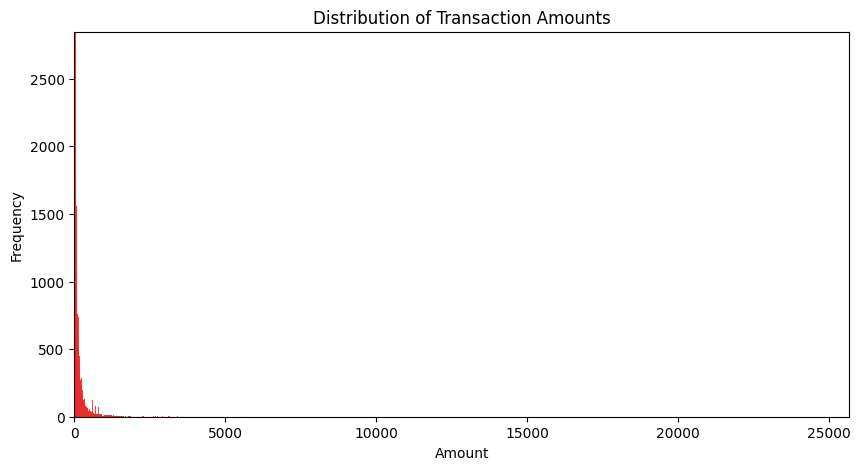

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(df["Amount"], color="red")
plt.xlim(min(df["Amount"]), max(df["Amount"]))
plt.ylim(0, len(df)/100)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

### 🛠️ 3. Feature Engineering
Creating new features from "Amount" and "Time" to improve model performance.

In [8]:
df["Hour"] = (df["Time"] // 3600) % 24
df["Is_Peak_Hour"] = df["Hour"].apply(lambda x: 1 if 9 <= x <= 18 else 0)
df["Time_Diff"] = df["Time"].diff().fillna(0)

In [9]:
df["Log_Amount"] = np.log1p(df["Amount"])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Hour,Is_Peak_Hour,Time_Diff,Log_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0,1.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0,1.0,4.262539


In [10]:
print(df["Log_Amount"].describe())

count    284807.000000
mean          3.152188
std           1.656648
min           0.000000
25%           1.887070
50%           3.135494
75%           4.358822
max          10.153941
Name: Log_Amount, dtype: float64


c:\Users\LazlowG\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


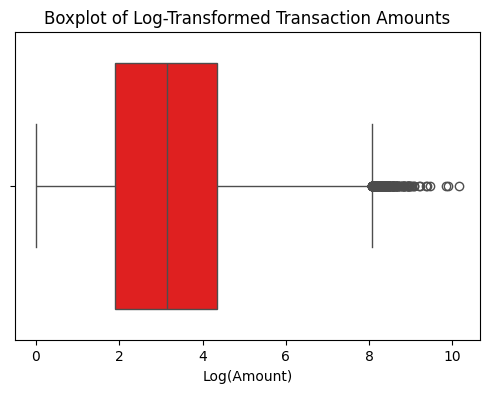

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Log_Amount"], color="red")
plt.title("Boxplot of Log-Transformed Transaction Amounts")
plt.xlabel("Log(Amount)")
plt.show()

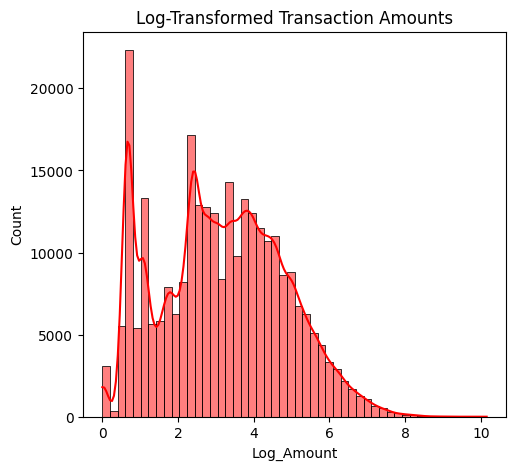

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,2)
sns.histplot(df["Log_Amount"], bins=50, kde=True, color="red")
plt.title("Log-Transformed Transaction Amounts")

plt.show()

In [13]:
fraud_mean = df[df["Class"] == 1]["Amount"].mean()
legit_mean = df[df["Class"] == 0]["Amount"].mean()

print(f"Average amount for fraudulent transactions: {fraud_mean:.2f}")
print(f"Average amount for normal transactions: {legit_mean:.2f}")

Average amount for fraudulent transactions: 122.21
Average amount for normal transactions: 88.29


### 📊 Hypothesis Testing Results

- **T-statistic** = 2.93  
- **P-value** = 0.0036  

📌 **Interpretation:**  
- The **T-statistic (2.93)** indicates how many standard deviations the observed difference is from the null hypothesis.  
- The **P-value (0.0036)** represents the probability that the observed difference occurred **purely by chance**.  
- **Since P < 0.05**, the result is **statistically significant**, meaning we **reject the null hypothesis**.  

✅ **Conclusion:** There is a **significant difference** between the two samples.

In [14]:
fraud_amounts = df[df["Class"] == 1]["Amount"]
legit_amounts = df[df["Class"] == 0]["Amount"]

t_stat, p_value = ttest_ind(fraud_amounts, legit_amounts, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 2.93
P-value: 0.0036


In [15]:
high_amount_threshold = df["Log_Amount"].quantile(0.99)
df["Is_High_Amount"] = (df["Log_Amount"] > high_amount_threshold).astype(int)

In [16]:
df["Night_High_Amount"] = df.apply(lambda x: 1 if x["Is_High_Amount"] == 1 and (x["Hour"] < 6 or x["Hour"] > 22) else 0, axis=1)

In [17]:
df = df.drop(columns=["Amount", "Time"])

In [18]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,Class,Hour,Is_Peak_Hour,Time_Diff,Log_Amount,Is_High_Amount,Night_High_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.189115,0.133558,-0.021053,0,0.0,0,0.0,5.014760,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.125895,-0.008983,0.014724,0,0.0,0,0.0,1.305626,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.139097,-0.055353,-0.059752,0,0.0,0,1.0,5.939276,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.221929,0.062723,0.061458,0,0.0,0,0.0,4.824306,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.502292,0.219422,0.215153,0,0.0,0,1.0,4.262539,0,0


### ⚖️ 4. Handling Class Imbalance (SMOTE), Set Train Test Datasets
Since fraudulent transactions are very rare, we use the SMOTE algorithm to balance the dataset. Set the train and test datasets for training.

In [19]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y.value_counts())
print("New class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())

Original class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
New class distribution after SMOTE:
 Class
0    227451
1     45490
Name: count, dtype: int64


### 🤖 5. Model Training and Evaluation
We train both Random Forest and XGBoost models and evaluate their performance.

#### -- Random Forest Classifier --

In [20]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

rf_model.fit(X_train_smote, y_train_smote)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



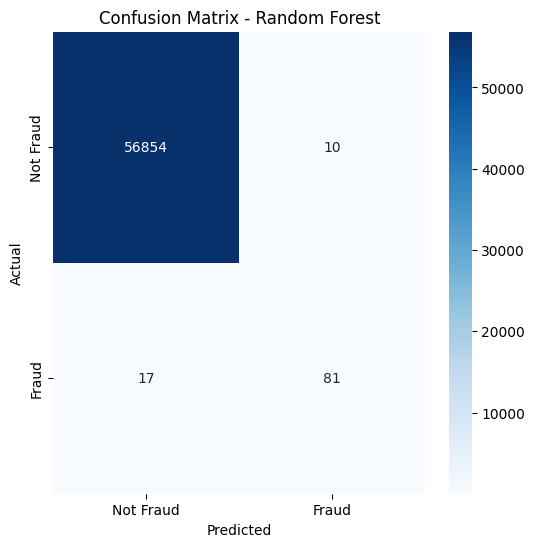

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#### -- XGB Classifier --

In [22]:
xgb_model = XGBClassifier(n_estimators=200, scale_pos_weight=len(y_train) / sum(y_train), random_state=42)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.85      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



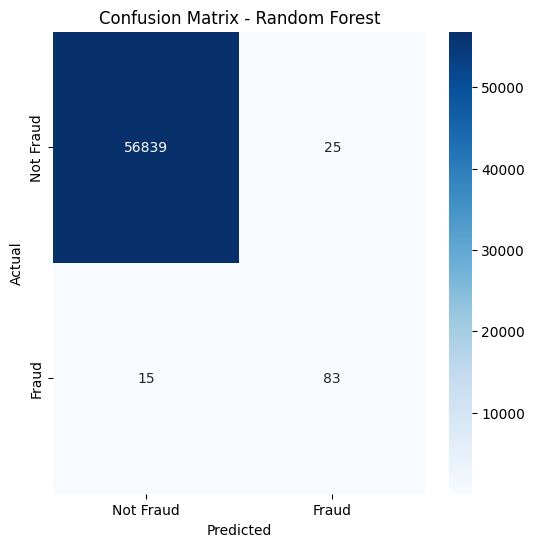

In [23]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

To improve the performance of our **XGBoost model**, we perform **hyperparameter tuning** using `GridSearchCV`.  
This process systematically tests different parameter combinations to find the best-performing model.

### 🔹 Parameters Tuned:
- **`n_estimators`** → Number of boosting rounds (`100, 200, 300`)
- **`max_depth`** → Maximum depth of trees (`3, 5, 7`)
- **`learning_rate`** → Step size for each boosting iteration (`0.01, 0.1, 0.2`)
- **`subsample`** → Fraction of data used per boosting round (`0.8, 1.0`)

### 🔹 Process:
1️⃣ `GridSearchCV` evaluates multiple combinations of these hyperparameters using **3-fold cross-validation**.  
2️⃣ The **best hyperparameters** are selected based on **F1-score**.  
3️⃣ We retrain the model (`best_xgb`) using these optimal settings.  
4️⃣ Finally, we **predict on the test set** and print the classification report.

✅ **Why is this important?**  
- Prevents **overfitting** by selecting the most generalizable parameters.  
- Improves **model accuracy** by finding the optimal trade-off between bias and variance. 

In [24]:
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 1.0]  
}

grid_search = GridSearchCV(XGBClassifier(scale_pos_weight=len(y_train_smote) / sum(y_train_smote), random_state=42), 
                           param_grid, cv=3, scoring='f1', verbose=2)

grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_

y_pred_best = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   4.1

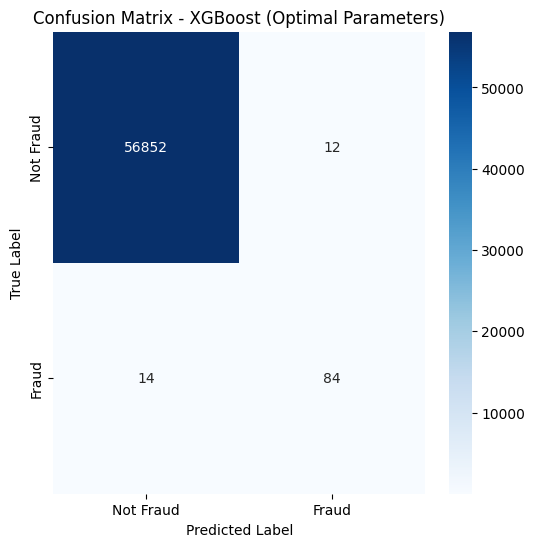

In [25]:
y_pred_best = best_xgb.predict(X_test)

cm_best_xgb = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,6))
sns.heatmap(cm_best_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost (Optimal Parameters)")
plt.show()